In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from copy import deepcopy
import pickle as pkl
from tqdm import tqdm
import pandas as pd

from sim_cosmology import p, load_dataloader_and_pretrained_model
p.data_path = '../../src/dsets/cosmology/data'
p.model_path = '../../src/dsets/cosmology/data'
# adaptive-wavelets modules
from losses import get_loss_f
from train import Trainer
from evaluate import Validator
from transform2d import DWT2d
from utils import get_1dfilts, get_2dfilts, get_wavefun
from wave_attributions import Attributer
from visualize import cshow, plot_1dfilts, plot_2dfilts, plot_2dreconstruct, plot_wavefun

# peakcounting
from astropy.io import fits
import cv2
from skimage.filters import sobel
import torch.nn.functional as F

In [2]:
# get dataloader and model
(train_loader, test_loader), model = load_dataloader_and_pretrained_model(p, img_size=256)

In [59]:
class PeakCount():
    """ Peak counting model."""
    
    def __init__(self, peak_counting_method='custom',
                 bins=np.arange(-0.03,0.19,0.01),
                 kernel=None):
        self.peak_counting_method = peak_counting_method
        self.bins = bins
        self.kernel = kernel[None,None] if kernel is not None else kernel
        assert self.peak_counting_method in ['original',
                                             'laplace_v1',
                                             'laplace_v2',
                                             'roberts_cross',
                                             'custom']
        if self.peak_counting_method == 'custom':
            assert kernel is not None, "if using custom kernel, must also pass kernel!"
        
        
    def fit(self, dataloader):
        """Calculate the mean peak counts and covariances."""
        self.peak_list = {}
        for data, params in dataloader:
            n_batch = data.size(0)
            hps = self.peak_count(data)
            for i in range(n_batch):
                params_list = tuple([params[i,k].item() for k in range(3)])
                if params_list in self.peak_list:
                    self.peak_list[params_list].append(hps[i])
                else:
                    self.peak_list[params_list] = [hps[i]]

        self.mean_peaks = {}  
        self.inv_cov = {}   
        for k,v in self.peak_list.items():
            self.mean_peaks[k] = np.mean(v, axis=0)
            vm = np.vstack(v).T
            self.inv_cov[k] = np.linalg.pinv(np.cov(vm))                       
                

    def predict(self, dataloader):
        """Predict on image with peak counts."""
        y_preds = []
        y_params = []
        ks = sorted(self.mean_peaks.keys())
        for data, params in dataloader:
            n_batch = data.size(0)
            hps = self.peak_count(data)
            
            chis = []
            for k in ks:
                d = hps - self.mean_peaks[k]
                chis.append((d.T * (self.inv_cov[k] @ d.T)).sum(axis=0))
            chis = np.vstack(chis).T
            idx = np.argmin(chis, axis=1)
            
            preds = []
            for i in idx:
                preds.append(ks[i])
            preds = np.vstack(preds)  
            y_preds.append(preds)
            y_params.append(params.cpu().numpy())
        y_preds = np.vstack(y_preds)
        y_params = np.vstack(y_params)
        return y_preds, y_params


    def find_peaks(self, ims):
        """Find peaks in bw image."""
        assert len(ims.shape)==4, "shape = (batch size, n_channel, height, width)"
        p =  ims[...,1:-1,1:-1] > ims[...,:-2,:-2]  # top left
        p &= ims[...,1:-1,1:-1] > ims[...,:-2,1:-1]  # top center  
        p &= ims[...,1:-1,1:-1] > ims[...,:-2,2:]  # top right
        p &= ims[...,1:-1,1:-1] > ims[...,1:-1,:-2]  # center left 
        p &= ims[...,1:-1,1:-1] > ims[...,1:-1,2:]  # center right 
        p &= ims[...,1:-1,1:-1] > ims[...,2:,:-2]  # bottom left
        p &= ims[...,1:-1,1:-1] > ims[...,2:,1:-1]  # bottom center
        p &= ims[...,1:-1,1:-1] > ims[...,2:,2:]   # bottom right
        return p
    

    def laplace_v1(self, ims):
        """Characterize peaks with laplace kernel in image."""
        L = 10/3 * torch.tensor([[-0.05, -0.2, -0.05], 
                                 [-0.2, 1.0, -0.2], 
                                 [-0.05, -0.2, -0.05]])  
        L = L[None,None]
        ims_f = F.conv2d(ims, L)
        return ims_f
    

    def laplace_v2(self, ims):
        """Characterize peaks with laplace kernel in image."""
        L = 4 * torch.tensor([[0, -0.25, 0], 
                              [-0.25, 1.0, -0.25], 
                              [0, -0.25, 0]])   
        L = L[None,None]
        ims_f = F.conv2d(ims, L)
        return ims_f
    

    def roberts_cross(self, ims):
        """Evaluate Robert's cross gradient magnitude."""
        Rx = torch.tensor([[0.0, 1.0], 
                           [-1.0, 0.0]])
        Ry = torch.tensor([[1.0, 0.0], 
                           [0.0, -1.0]])  
        Rx = Rx[None,None]
        Ry = Ry[None,None]
        p0 = F.conv2d(ims[...,:-1,:-1], Rx)**2
        p0 += F.conv2d(ims[...,:-1,:-1], Ry)**2
        p0 = torch.sqrt(p0)
        p1 = F.conv2d(ims[...,:-1,1:], Rx)**2
        p1 += F.conv2d(ims[...,:-1,1:], Ry)**2
        p1 = torch.sqrt(p1)
        p2 = F.conv2d(ims[...,1:,:-1], Rx)**2
        p2 += F.conv2d(ims[...,1:,:-1], Ry)**2
        p2 = torch.sqrt(p2)    
        p3 = F.conv2d(ims[...,1:,1:], Rx)**2
        p3 += F.conv2d(ims[...,1:,1:], Ry)**2
        p3 = torch.sqrt(p3)    
        return (p0+p1+p2+p3)
    

    def images_at_peaks(self, ims_f, p):
        """Get filtered images at the position of peaks"""
        n_batch = p.size(0)
        vals = ims_f[p]    
        n_peaks = p.sum(axis=(1,2,3))
        n_peaks = n_peaks.cpu().numpy()
        idx = list(np.cumsum(n_peaks))
        idx.insert(0,0) # index starts from 0
        results = []
        for i in range(n_batch):
            left, right = idx[i], idx[i+1]
            vals_b = vals[left:right]
            results.append(vals_b.cpu().numpy())    
        return results
    

    def peak_count(self, ims):
        """Peak counting statistics"""
        peaks = self.find_peaks(ims)  # find peaks  

        # get the values for peaks
        if self.peak_counting_method == 'original':
            ims_f = ims[...,1:-1,1:-1]
        elif self.peak_counting_method == 'laplace_v1':
            ims_f = self.laplace_v1(ims)
        elif self.peak_counting_method == 'laplace_v2':
            ims_f = self.laplace_v2(ims)
        elif self.peak_counting_method == 'roberts_cross':
            ims_f = self.roberts_cross(ims)
        elif self.peak_counting_method == 'custom':
            ims_f = F.conv2d(ims, self.kernel)
        vals = self.images_at_peaks(ims_f, peaks)
        
        # make histogram
        results = []
        for i,val in enumerate(vals):
            hp = np.histogram(val, bins=self.bins)[0]
            results.append(hp)    
        return np.vstack(results) 

In [15]:
pco = PeakCount(peak_counting_method='original')
pco.fit(train_loader)
y_preds, y_params = pco.predict(test_loader)
err = np.linalg.norm(y_preds - y_params)**2/np.prod(y_params.shape)
print(err)

0.02387063281217712


In [16]:
pco = PeakCount(peak_counting_method='laplace_v1')
pco.fit(train_loader)
y_preds, y_params = pco.predict(test_loader)
err = np.linalg.norm(y_preds - y_params)**2/np.prod(y_params.shape)
print(err)

0.016314508525576595


In [17]:
pco = PeakCount(peak_counting_method='laplace_v2')
pco.fit(train_loader)
y_preds, y_params = pco.predict(test_loader)
err = np.linalg.norm(y_preds - y_params)**2/np.prod(y_params.shape)
print(err)

0.016613842504681356


In [18]:
pco = PeakCount(peak_counting_method='roberts_cross')
pco.fit(train_loader)
y_preds, y_params = pco.predict(test_loader)
err = np.linalg.norm(y_preds - y_params)**2/np.prod(y_params.shape)
print(err)

0.018228402554810817


# Compare

In [62]:
pco = PeakCount(peak_counting_method='laplace_v1', bins=np.arange(-0.01,0.23,0.01))
pco.fit(train_loader)
y_preds, y_params = pco.predict(test_loader)
err = np.linalg.norm(y_preds - y_params)**2/np.prod(y_params.shape)
print(err)

0.01904301093603755


In [63]:
kernel = 3 * torch.tensor([[ 0.1414, -0.3014,  0.1642],
                       [-0.3014,  0.6425, -0.3502],
                       [ 0.1642, -0.3502,  0.1908]])
kernel -= kernel.mean()
pco = PeakCount(peak_counting_method='custom', bins=np.arange(-0.01,0.23,0.01), kernel=kernel)
pco.fit(train_loader)
y_preds, y_params = pco.predict(test_loader)
err = np.linalg.norm(y_preds - y_params)**2/np.prod(y_params.shape)
print(err)

0.026835996537294314


In [64]:
L = 10/3 * torch.tensor([[-0.05, -0.2, -0.05], 
                         [-0.2, 1.0, -0.2], 
                         [-0.05, -0.2, -0.05]]) 
L = L[None,None]

kernel = 3*torch.tensor([[ 0.1414, -0.3014,  0.1642],
                       [-0.3014,  0.6425, -0.3502],
                       [ 0.1642, -0.3502,  0.1908]])
kernel = kernel[None,None]

In [65]:
peaks = pco.find_peaks(data)
vals = pco.images_at_peaks(F.conv2d(data, L), peaks)

(array([2.8173e+05, 2.9773e+04, 3.8960e+03, 7.9000e+02, 1.9700e+02,
        6.9000e+01, 3.2000e+01, 6.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([0.00118126, 0.069414  , 0.13764675, 0.2058795 , 0.27411222,
        0.34234497, 0.4105777 , 0.47881046, 0.5470432 , 0.615276  ,
        0.6835087 ], dtype=float32),
 <a list of 10 Patch objects>)

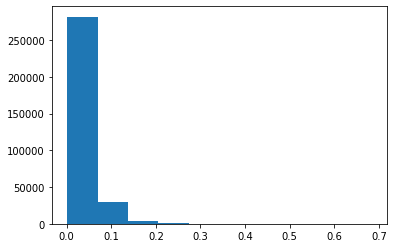

In [66]:
plt.hist(np.hstack(vals))

In [67]:
print(np.min(np.hstack(vals)), np.max(np.hstack(vals)))

0.0011812564 0.6835087


In [68]:
peaks = pco.find_peaks(data)
vals = pco.images_at_peaks(F.conv2d(data, kernel), peaks)

(array([1.08310e+04, 2.80898e+05, 2.19320e+04, 2.26200e+03, 4.30000e+02,
        9.90000e+01, 3.10000e+01, 6.00000e+00, 3.00000e+00, 4.00000e+00]),
 array([-0.02608205,  0.00033179,  0.02674563,  0.05315947,  0.07957331,
         0.10598715,  0.13240099,  0.15881483,  0.18522868,  0.2116425 ,
         0.23805635], dtype=float32),
 <a list of 10 Patch objects>)

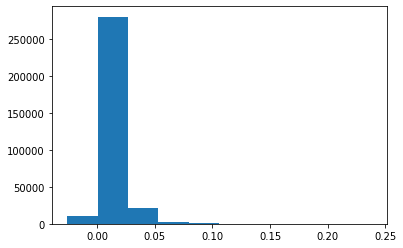

In [69]:
plt.hist(np.hstack(vals))

In [70]:
print(np.min(np.hstack(vals)), np.max(np.hstack(vals)))

-0.026082046 0.23805635
